In [15]:
import os
import math

%matplotlib inline
import matplotlib.pyplot as plt

from altusi import utils
import altusi.utils.visualizer as vis
import altusi.configs.config as cfg
from altusi import learning
from altusi.utils.logger import *

In [16]:
import numpy as np

import mxnet as mx
from mxnet import nd, autograd, gluon, context
from mxnet.gluon.data.vision import transforms, CIFAR10
from gluoncv.data import transforms as gcv_transforms

In [17]:
train_transformer = transforms.Compose([
    gcv_transforms.RandomCrop(cfg.IMAGE_SIZE, pad=4),
    transforms.RandomFlipLeftRight(),
    transforms.ToTensor(),
    transforms.Normalize(cfg.CIFAR10_MEAN, cfg.CIFAR10_STD)
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cfg.CIFAR10_MEAN, cfg.CIFAR10_STD)
])

LOG(INFO, 'Data Transformers defining done')

[2022-05-03 15:12:22] [INFO]  Data Transformers defining done


In [18]:
train_dataset = CIFAR10(train=True)
test_dataset = CIFAR10(train=False)

LOG(INFO, 'Dataset loading done')

[2022-05-03 15:12:48] [INFO]  Dataset loading done


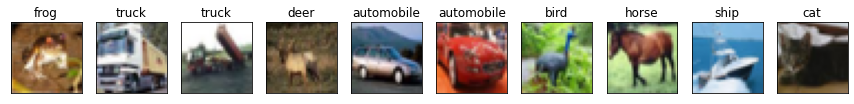

In [19]:
X, y = train_dataset[:10]

vis.show_images(X, 1, 10, titles=[cfg.CIFAR_CLASSES[cls] for cls in y])

In [20]:
BATCH_SIZE = cfg.BATCH_SIZE

train_loader = gluon.data.DataLoader(
    train_dataset.transform_first(train_transformer),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

test_loader = gluon.data.DataLoader(
    test_dataset.transform_first(test_transformer),
    batch_size=BATCH_SIZE,
    num_workers=4
)

LOG(INFO, 'Data Loaders defining done')

[2022-05-03 15:12:54] [INFO]  Data Loaders defining done


In [21]:
from altusi.models import AlexNet
from altusi.models import VGG11, VGG13, VGG16, VGG19
from altusi.models import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from altusi.models import DenseNet121, DenseNet161, DenseNet169, DenseNet201
from altusi.models import GoogleNet, InceptionV3

# AlexNet architecture
# net = AlexNet(nclasses=cfg.CIFAR_NCLASSES); model_name = 'AlexNet'

# VGG architectures
# net = VGG11(nclasses=cfg.CIFAR_NCLASSES); model_name = 'VGG11'
# net = VGG13(nclasses=cfg.CIFAR_NCLASSES); model_name = 'VGG13'
# net = VGG16(nclasses=cfg.CIFAR_NCLASSES); model_name = 'VGG16'
# net = VGG19(nclasses=cfg.CIFAR_NCLASSES); model_name = 'VGG19'

# ResNet architectures
# net = ResNet18(nclasses=cfg.CIFAR_NCLASSES); model_name = 'ResNet18'
# net = ResNet34(nclasses=cfg.CIFAR_NCLASSES); model_name = 'ResNet34'
# net = ResNet50(nclasses=cfg.CIFAR_NCLASSES); model_name = 'ResNet50'
net = ResNet101(nclasses=cfg.CIFAR_NCLASSES); model_name = 'ResNet101'
# net = ResNet152(nclasses=cfg.CIFAR_NCLASSES); model_name = 'ResNet152'

# DenseNet architectures
# net = DenseNet121(nclasses=cfg.CIFAR_NCLASSES); model_name = 'DenseNet121'
# net = DenseNet161(nclasses=cfg.CIFAR_NCLASSES); model_name = 'DenseNet161'
# net = DenseNet169(nclasses=cfg.CIFAR_NCLASSES); model_name = 'DenseNet169'
# net = DenseNet201(nclasses=cfg.CIFAR_NCLASSES); model_name = 'DenseNet201'


# Inception architecture
# net = GoogleNet(nclasses=cfg.CIFAR_NCLASSES); model_name = 'GoogleNet'
# net = InceptionV3(nclasses=cfg.CIFAR_NCLASSES); model_name = 'InceptionV3'


LOG(INFO, '{} Network setup done'.format(model_name))

[2022-05-03 15:13:05] [INFO]  ResNet101 Network setup done


In [22]:
net.hybridize()
net.initialize(force_reinit=True)

X = nd.random.uniform(shape=(1, 3, 32, 32))

net(X)


[[ 1.6569859  -0.798399   -1.267931   -1.1246127  -0.4675028   1.4339556
   0.41305667 -2.5317748   2.1251986   0.75195616]]
<NDArray 1x10 @cpu(0)>

In [23]:
ctx = context.gpu(0) if context.num_gpus() else context.cpu()

LOG(INFO, 'Device in Use:', ctx)

[2022-05-03 15:13:20] [INFO]  Device in Use: cpu(0)


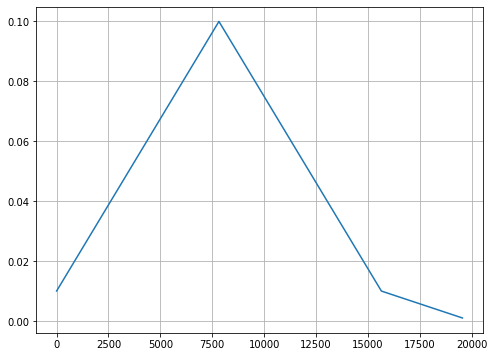

In [24]:

# learning rate scheduler
iter_per_epochs = math.ceil(len(train_dataset) / BATCH_SIZE)
niterations = cfg.NEPOCHS * iter_per_epochs

lr_scheduler = learning.OneCycleScheduler(start_lr=0.01, max_lr=0.1,
                                          cycle_length=40*iter_per_epochs, 
                                          cooldown_length=niterations - 40*iter_per_epochs, 
                                          finish_lr=0.001)

iters = [i+1 for i in range(iter_per_epochs * cfg.NEPOCHS)]

lrs = [lr_scheduler(i) for i in iters]

vis.plot(iters, lrs, figsize=(8, 6))

In [25]:
# loss function
criterion = gluon.loss.SoftmaxCrossEntropyLoss()


# optimizer
optimizer = mx.optimizer.SGD(momentum=cfg.MOMENTUM, 
                             wd=cfg.WD, 
                             lr_scheduler=lr_scheduler)

net.initialize(init=mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()

trainer = gluon.Trainer(net.collect_params(), optimizer)

LOG(INFO, 'Training system setup done')

[2022-05-03 15:13:32] [INFO]  Training system setup done


In [26]:
def evaluate_accuracy_loss(net, loader, criterion, ctx):
    metric = mx.metric.Accuracy()
    loss = 0
    sample_cnt = 0
    
    for i, (X, y) in enumerate(loader):
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        
        y_hat = net(X)
        l = criterion(y_hat, y)
        
        metric.update(labels=[y], preds=[y_hat])
        loss += l.sum().asscalar()
        sample_cnt += X.shape[0]
        
    return metric.get(), loss / sample_cnt

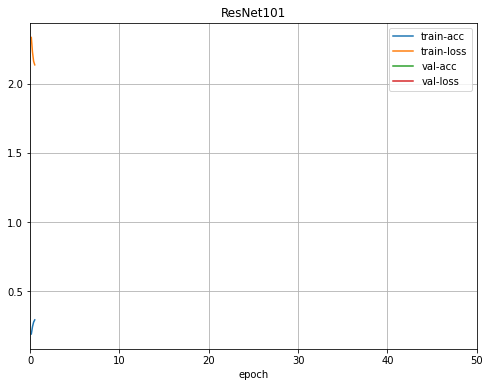

In [ ]:
animator = vis.Animator(
    title=model_name, xlabel='epoch',
    legend=['train-acc', 'train-loss', 'val-acc', 'val-loss'],
    xlim=[0, cfg.NEPOCHS],
    figsize=(8, 6)
)

train_metric = mx.metric.Accuracy()
best_val_acc = 0

for epoch in range(cfg.NEPOCHS):
    train_metric.reset()
    train_loss_total = 0
    sample_cnt = 0
           
    for i, (X, y) in enumerate(train_loader):
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        
        with autograd.record():
            y_hat = net(X)
            l = criterion(y_hat, y)
        l.backward()
        trainer.step(X.shape[0])
        
        train_metric.update(labels=[y], preds=[y_hat])
        train_loss_total += l.sum().asscalar()
        sample_cnt += X.shape[0]
        
        name, train_acc = train_metric.get()
        train_loss = train_loss_total / sample_cnt
        
        if (i+1) % 50 == 0 or i+1 == len(train_loader):
            animator.add(epoch + i/len(train_loader), 
                        (train_acc, train_loss, None, None))
            
    (name, val_acc), val_loss = evaluate_accuracy_loss(net, test_loader, criterion, ctx)
    animator.add(epoch+1, (None, None, val_acc, val_loss))
    
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        saved_model_name = '{}-epoch-{:02d}-acc-{:.4f}.params'.format(
            model_name.lower(), epoch+1, best_val_acc)
        net.save_parameters(os.path.join(cfg.CHECKPOINTS, saved_model_name))
    
    LOG(INFO, 'Epoch:', epoch+1)
    LOG(INFO, '\ttrain-acc:  {:.6f}'.format(train_acc))
    LOG(INFO, '\ttrain-loss: {:.6f}'.format(train_loss))
    LOG(INFO, '\tval-acc:    {:.6f}'.format(val_acc))
    LOG(INFO, '\tval-loss:   {:.6f}'.format(val_loss))
    
    
history_image_name = '{}-acc-{:.4f}.png'.format(model_name.lower(), best_val_acc)
animator.savefig(save_path=os.path.join(cfg.HISTORY, history_image_name))

LOG(INFO, 'Training Procedure done')

In [ ]:
from altusi.models import AlexNet
from altusi.models import VGG11, VGG13, VGG16, VGG19
from altusi.models import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from altusi.models import DenseNet121, DenseNet161, DenseNet169, DenseNet201
from altusi.models import GoogleNet, InceptionV3

# set device
ctx = context.gpu(0) if context.num_gpus() else context.cpu()

LOG(INFO, 'Device in Use:', ctx)

# change to your trained models
trained_model_name = 'alexnet-epoch-50-acc-0.8967.params'
trained_model_name = 'vgg11-epoch-50-acc-0.9160.params'
trained_model_name = 'vgg13-epoch-50-acc-0.9366.params'
trained_model_name = 'vgg16-epoch-50-acc-0.9342.params'
trained_model_name = 'vgg19-epoch-50-acc-0.9287.params'
trained_model_name = 'resnet18-epoch-50-acc-0.9236.params'
trained_model_name = 'resnet34-epoch-49-acc-0.9239.params'
trained_model_name = 'resnet50-epoch-50-acc-0.9204.params'
trained_model_name = 'resnet101-epoch-50-acc-0.9152.params'
trained_model_name = 'resnet152-epoch-50-acc-0.9130.params'
trained_model_name = 'densenet121-epoch-50-acc-0.9186.params'
trained_model_name = 'densenet161-epoch-50-acc-0.9269.params'
trained_model_name = 'densenet169-epoch-50-acc-0.9131.params'
trained_model_name = 'densenet201-epoch-49-acc-0.9161.params'
trained_model_name = 'googlenet-epoch-50-acc-0.8691.params'
trained_model_name = 'inceptionv3-epoch-50-acc-0.9425.params'
trained_model_path = os.path.join(cfg.CHECKPOINTS, trained_model_name)

# AlexNet architecture
#trained_net = AlexNet(nclasses=cfg.CIFAR_NCLASSES)

# VGG architecture
# trained_net = VGG11(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = VGG13(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = VGG16(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = VGG19(nclasses=cfg.CIFAR_NCLASSES)

# ResNet architecture
# trained_net = ResNet18(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = ResNet34(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = ResNet50(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = ResNet101(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = ResNet152(nclasses=cfg.CIFAR_NCLASSES)

# DenseNet architecture
# trained_net = DenseNet121(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = DenseNet161(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = DenseNet169(nclasses=cfg.CIFAR_NCLASSES)
# trained_net = DenseNet201(nclasses=cfg.CIFAR_NCLASSES)

# Inception architecture
# trained_net = GoogleNet(nclasses=cfg.CIFAR_NCLASSES)
trained_net = InceptionV3(nclasses=cfg.CIFAR_NCLASSES)

# load network's parameter to specific hardware
trained_net.load_parameters(trained_model_path, ctx=ctx)

LOG(INFO, 'Training model loading done')

In [ ]:
for X, y in test_loader:
    break

rnd_idx = np.random.choice(BATCH_SIZE, 10, replace=False)

In [ ]:
test_images = X[rnd_idx].as_in_context(ctx)
y_hat = trained_net(test_images).argmax(axis=1).astype('int32').asnumpy()
y_preds = [cfg.CIFAR_CLASSES[cls] for cls in y_hat]

In [ ]:
_dataset = CIFAR10(train=False)
_loader = gluon.data.DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                num_workers=4)

for X, y in _loader:
    break
test_images = X[rnd_idx]

In [ ]:
vis.show_images(test_images, 1, 10, y_preds)

In [ ]:
vis.show_images(test_images, 1, 10, [cfg.CIFAR_CLASSES[cls] for cls in y[rnd_idx].asnumpy()])